In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

sns.set()

2022-10-22 19:00:45.132189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 19:00:45.245778: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 19:00:45.249952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 19:00:45.249965: I tensorf

## Load data

In [2]:
with open('../data/presidentielle.pkl', 'rb') as f:
    data = pickle.load(f)

df1 = data['df1']
df2 = data['df2']

prop1 = data['prop1']
prop2 = data['prop2']

colnames = data['colnames']

model = tf.keras.models.load_model('../models/prop1_to_prop2')

del data

2022-10-22 19:00:46.480838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 19:00:46.480883: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-22 19:00:46.480905: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-10-22 19:00:46.481111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Looking at predictions of model

We look at observed values against predicted values and overall see a good correlation between observed and predicted proportions.

In [3]:
# We retrieve predictions
prop2_hat = pd.DataFrame(model.predict(prop1, verbose=0))
prop2_hat.columns = prop2.columns
prop2_all = pd.merge(prop2, prop2_hat,
                       left_index=True, right_index=True,
                       suffixes=['_Observed', '_Predicted'])
prop2_all = pd.merge(df1[colnames['id']], prop2_all,
                       left_index=True, right_index=True)

# We compute the pointwise error per voting station
def error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1)
    return tf.math.abs(tf.math.log(y_true / y_pred))

for choice in colnames['choices2']:
    prop2_all[f'{choice}_Residual'] = error(
        prop2_all[f'{choice}_Observed'], 
        prop2_all[f'{choice}_Predicted'])

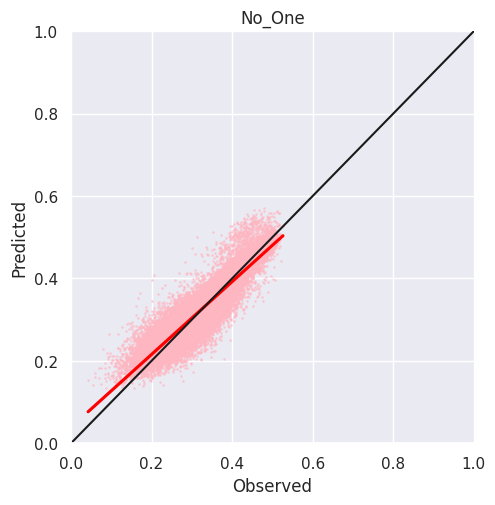

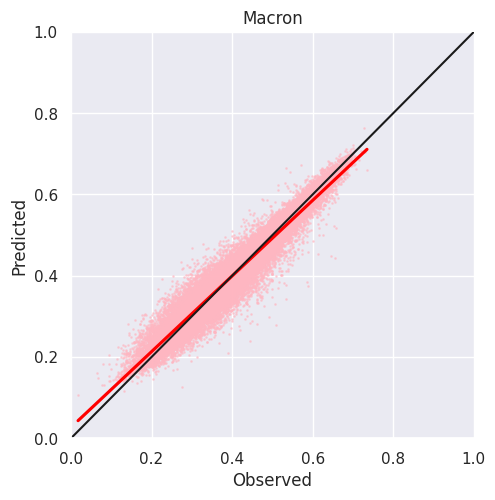

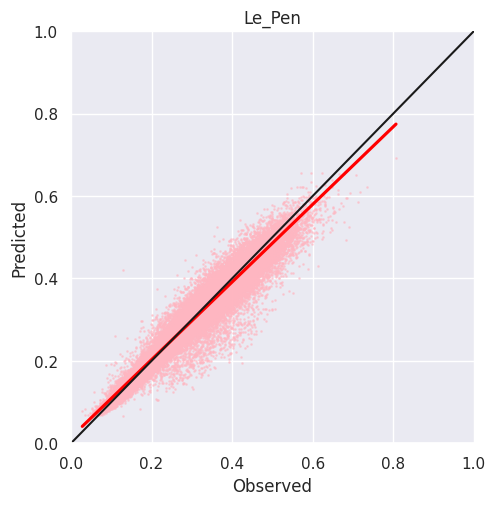

In [4]:
for choice in colnames['choices2']:
    sns.lmplot(data=prop2_all,
               x=f'{choice}_Observed',
               y=f'{choice}_Predicted',
               line_kws={'color': 'red'},
               scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5})
    plt.axline(xy1=(0, 0), slope=1, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(choice)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')

## Relation between the first and second round

We create hypothetical results using our trained model. For any voting station of the first round, we artificially deflate or inflate the results of a specific candidate, and use this new proportion to predict the second results using our model. This allows us to infer how the ballots of one first-round candidate are transferred to a second-round candidate.

We first define functions that allow us to study this relationship.

In [5]:
def predict_hypothetical_results(station_index, prop1, model):

    aux = []
    original_prop1 = prop1.iloc[station_index].copy()
    choice_prop1 = np.linspace(0, 30, 501)
    for choice in colnames['choices1']:
        new_prop1 = np.zeros(
            (choice_prop1.shape[0], original_prop1.shape[0]))
        for i in range(new_prop1.shape[0]):
            x = original_prop1.copy()
            x[choice] = choice_prop1[i]
            x = x/sum(x)
            new_prop1[i, :] = x

        new_prop1 = pd.DataFrame(new_prop1, columns=prop1.columns)
        new_prop2_hat = model.predict(new_prop1, verbose=0)
        new_prop2_hat = pd.DataFrame(
            new_prop2_hat, columns=prop2.columns)
        new_prop2_hat['FirstRoundProportion'] = new_prop1[choice]
        new_prop2_hat['FirstRoundCandidate'] = choice
        aux.append(new_prop2_hat)

    new_prop2_hat = pd.concat(aux, axis=0)
    return new_prop2_hat


def plot_hypothetical_results(new_prop2_hat, station_index,
                              df1,
                              prop1, prop2,
                              palette=['grey', 'darkred', 'darkblue']):

    data = new_prop2_hat.melt(id_vars=['FirstRoundCandidate',
                                        'FirstRoundProportion'])
    data['variable'] = data['variable'].str.replace('_', ' ')
    data['FirstRoundCandidate'] = (data['FirstRoundCandidate'].
                                str.
                                replace('_', ' '))

    commune = df1.iloc[station_index]['NomCommune']
    department = df1.iloc[station_index]['NomDepartement']
    station = df1.iloc[station_index]['CodeBureauVote']

    g = sns.FacetGrid(data=data,
                    col='FirstRoundCandidate', col_wrap=3)
    g.map_dataframe(sns.lineplot,
                    x='FirstRoundProportion', y='value',
                    hue='variable', palette=palette)
    g.set_xlabels(f'1st Round')
    g.set_ylabels(f'2nd Round')
    g.set_titles(col_template='{col_name}')
    g.fig.subplots_adjust(top=0.94)
    g.fig.suptitle(f'{commune}, {department}, {station}')
    g.axes[0].legend()
    for i, ax in enumerate(g.axes):
        ax.hlines(prop2.iloc[station_index], xmin=0, xmax=1,
                color=palette, linestyles='dashed', linewidths=.5)
        ax.vlines(prop1.iloc[station_index, i], ymin=0, ymax=1,
                color='k', linestyles='dashed', linewidths=.5)


We now plot results for 15 randomly chosen voting stations. 

We see two consistent trends:
- voters of Le Pen, Zémmour, and Dupont-Aignan tend to give their ballots to Le Pen;
- voters of Macron, Jadot, and Hidalgo tend to give their ballots to Macron;
- it's not possible to know who voters of Lassalle vote for in the second round.

There are more complex trends for Mélenchon, Roussel, and Poutou voters who, depending on the station, either transfer their ballot to Macron or decide not to choose any candidate. 

A curious result that may show the limits of the analysis concerns voters of Arthaud. It appears that these voters transfer their ballot to Le Pen, which is unexpected given that these two candidates are opposites on the political spectrum.

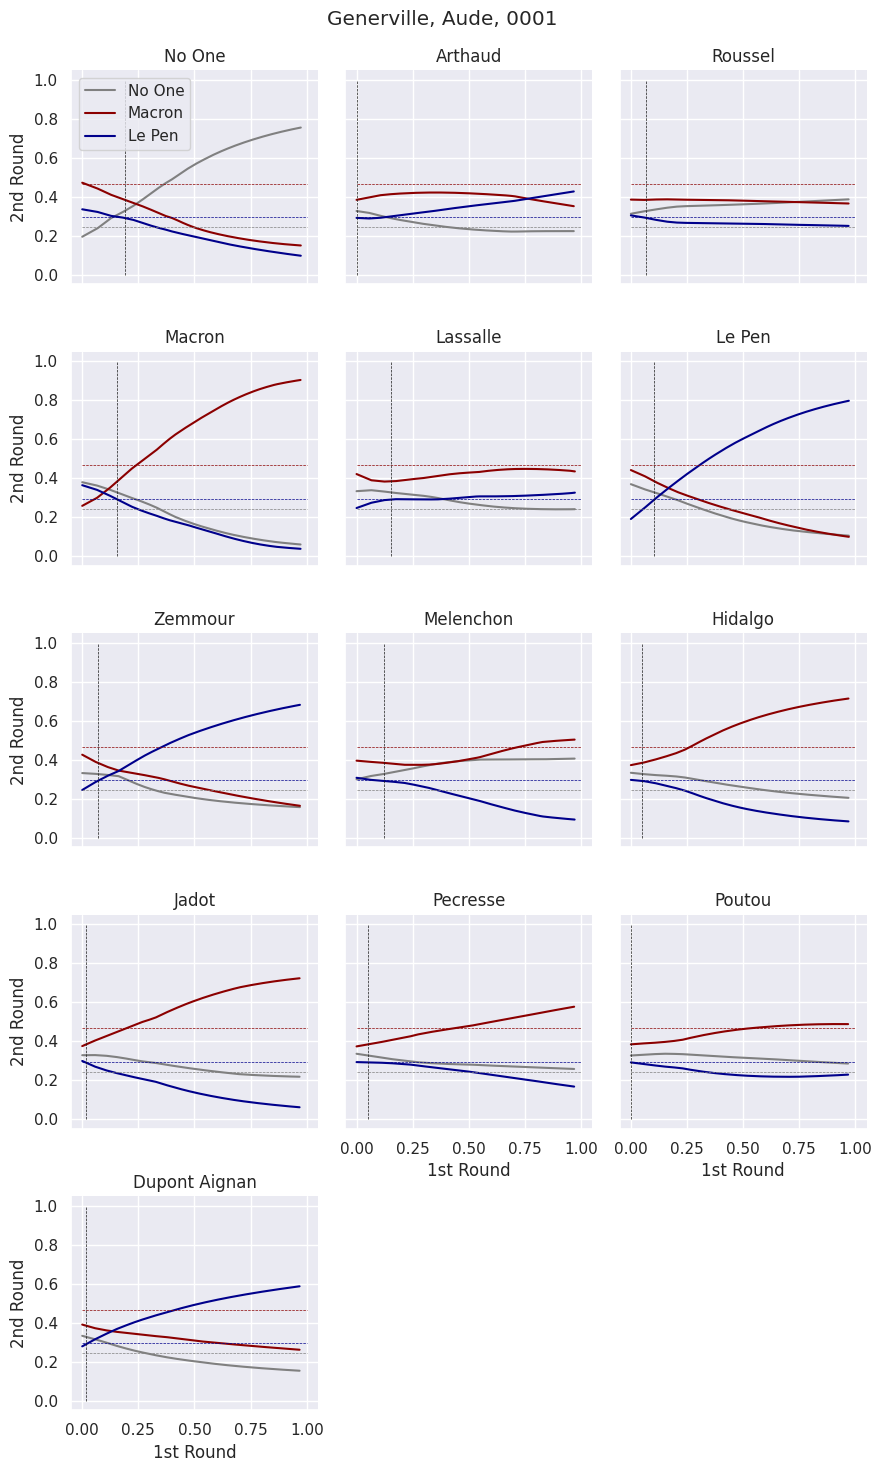

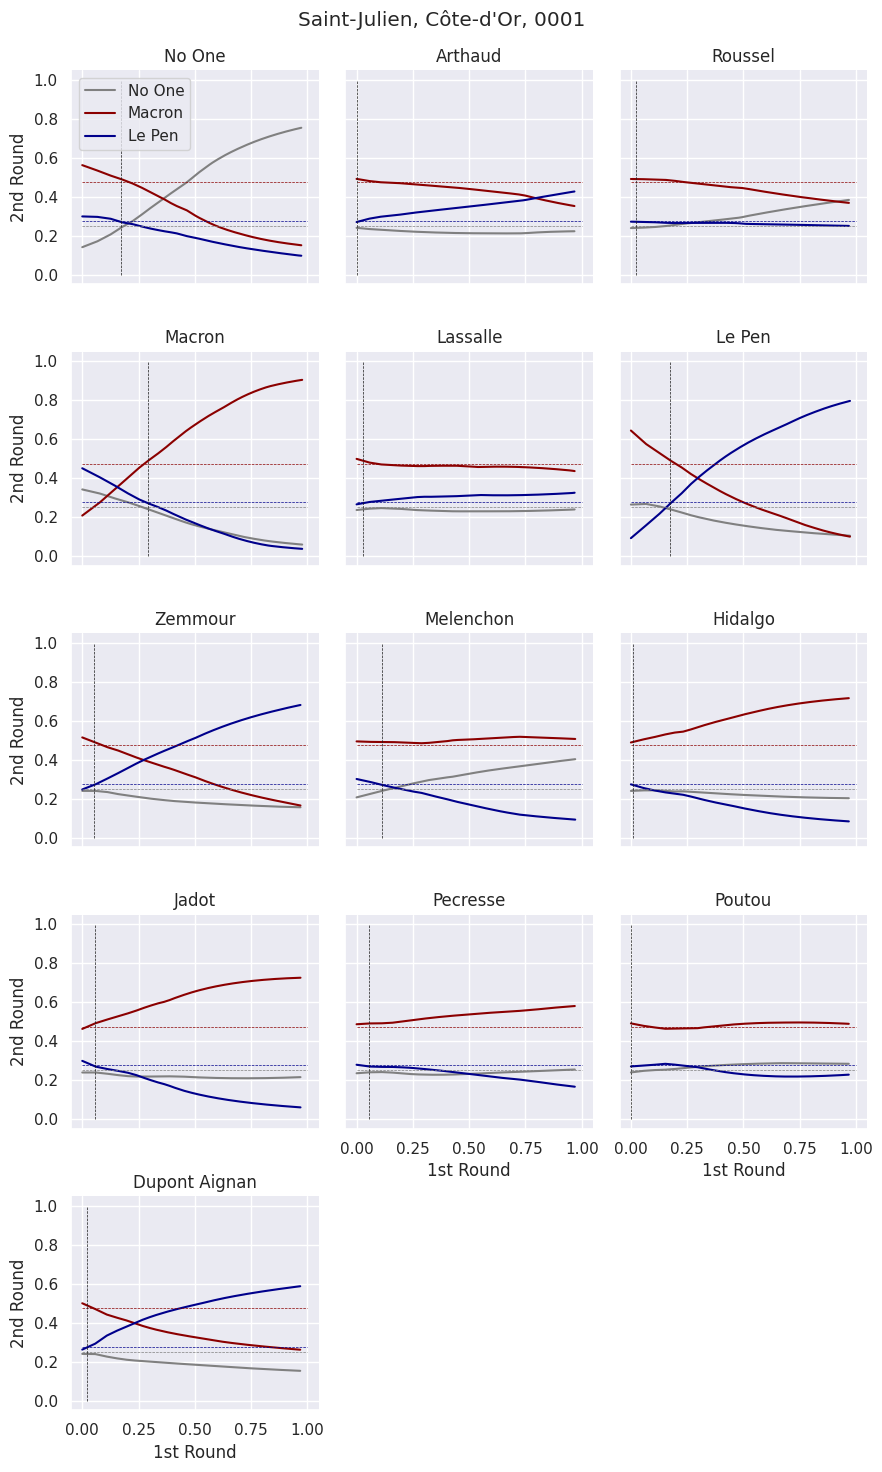

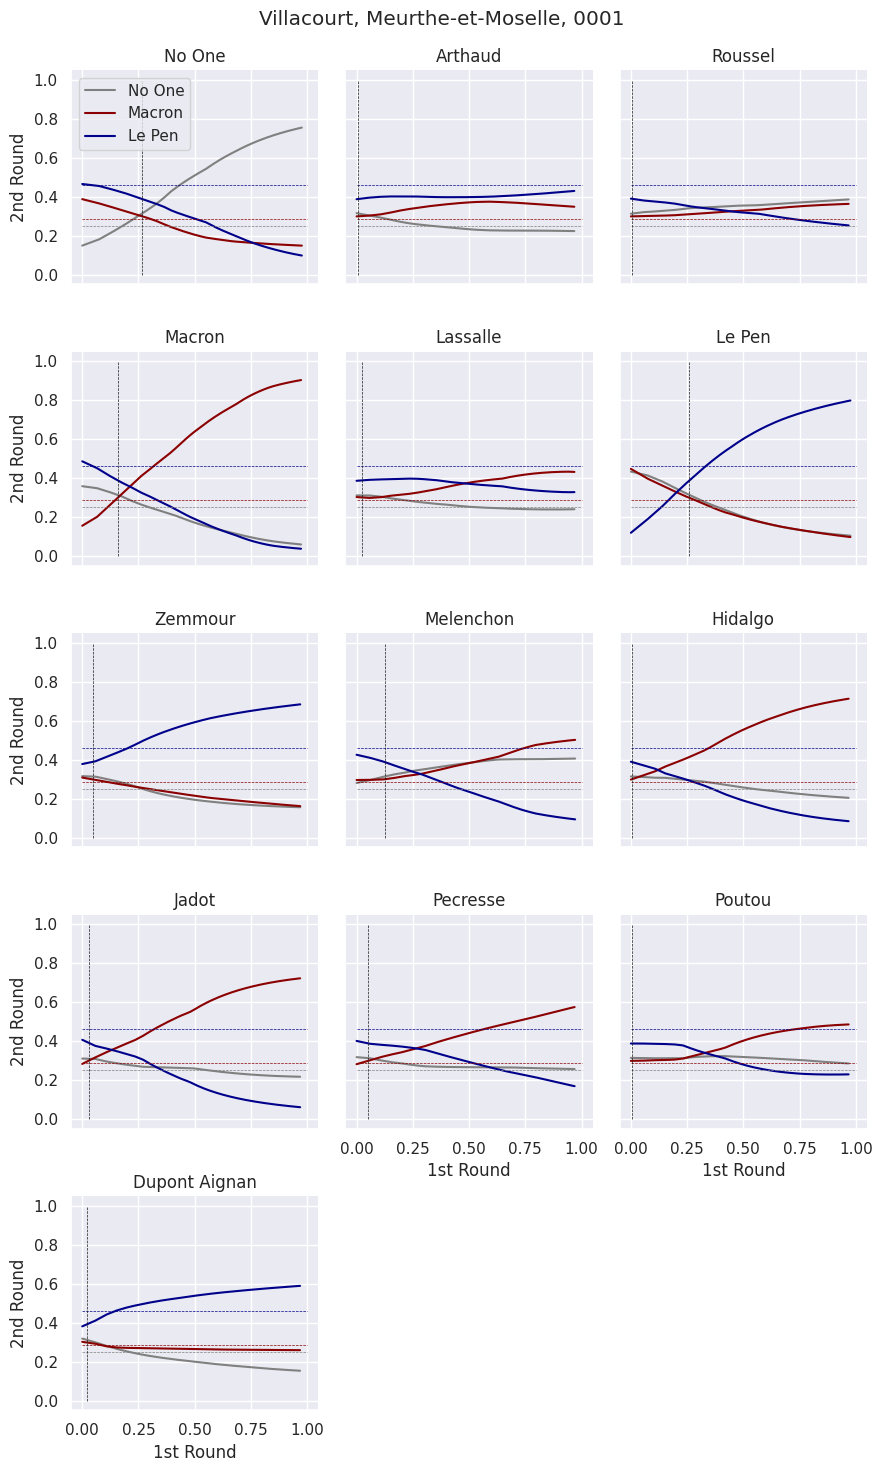

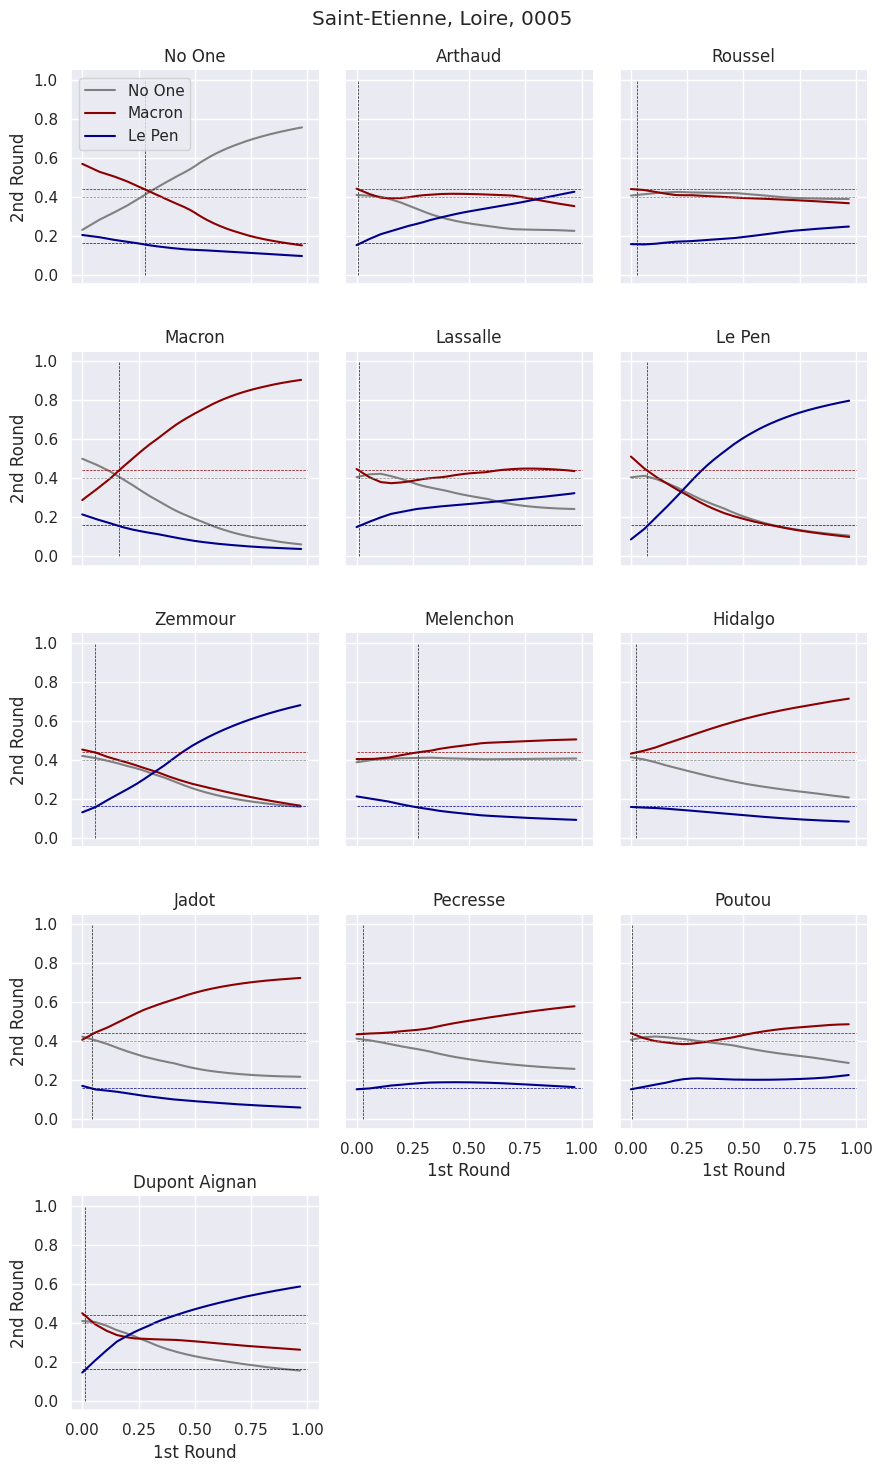

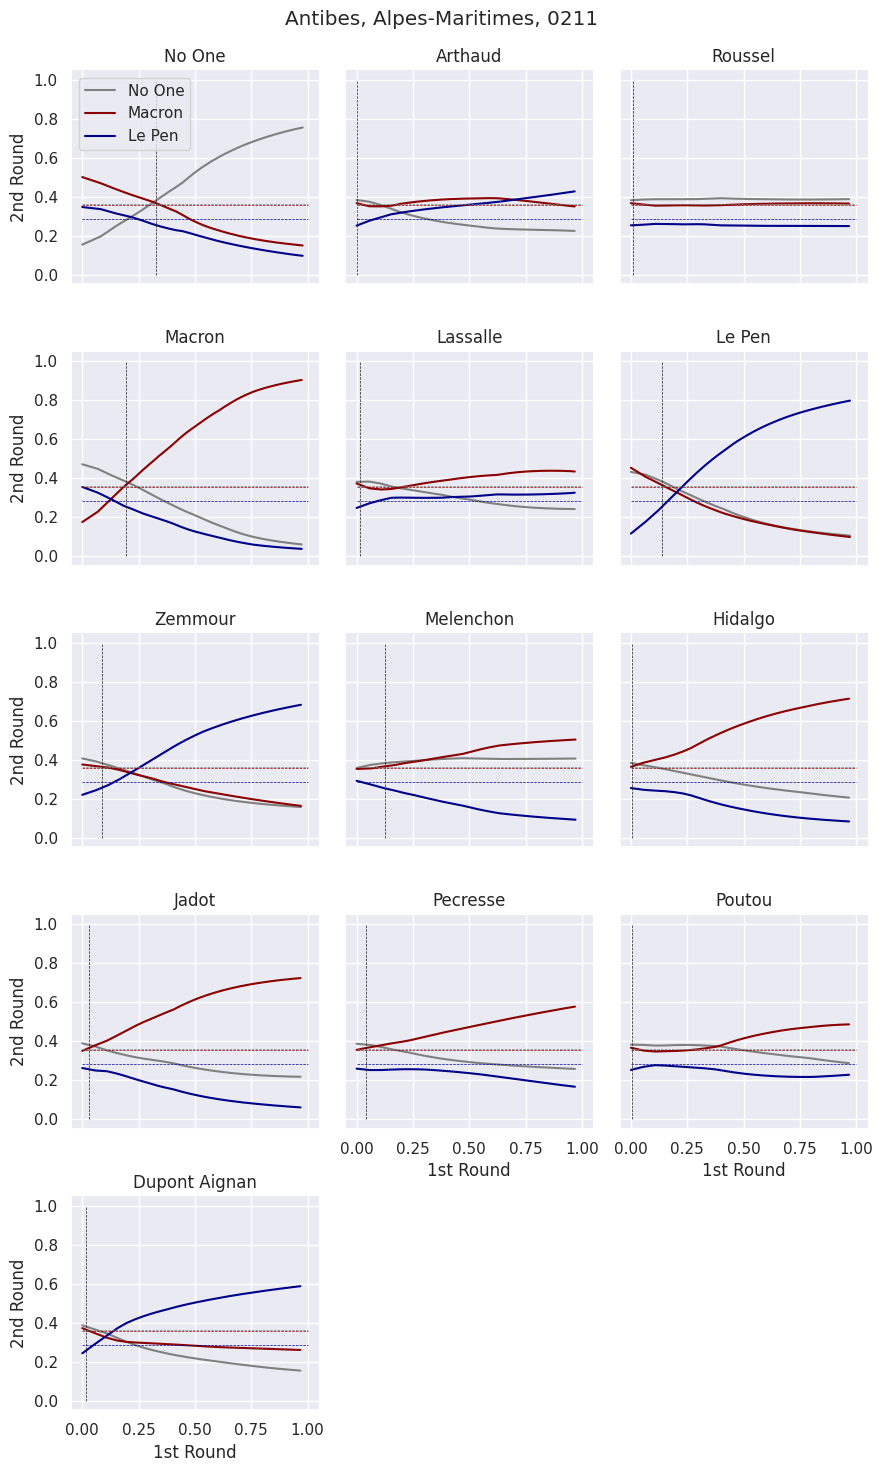

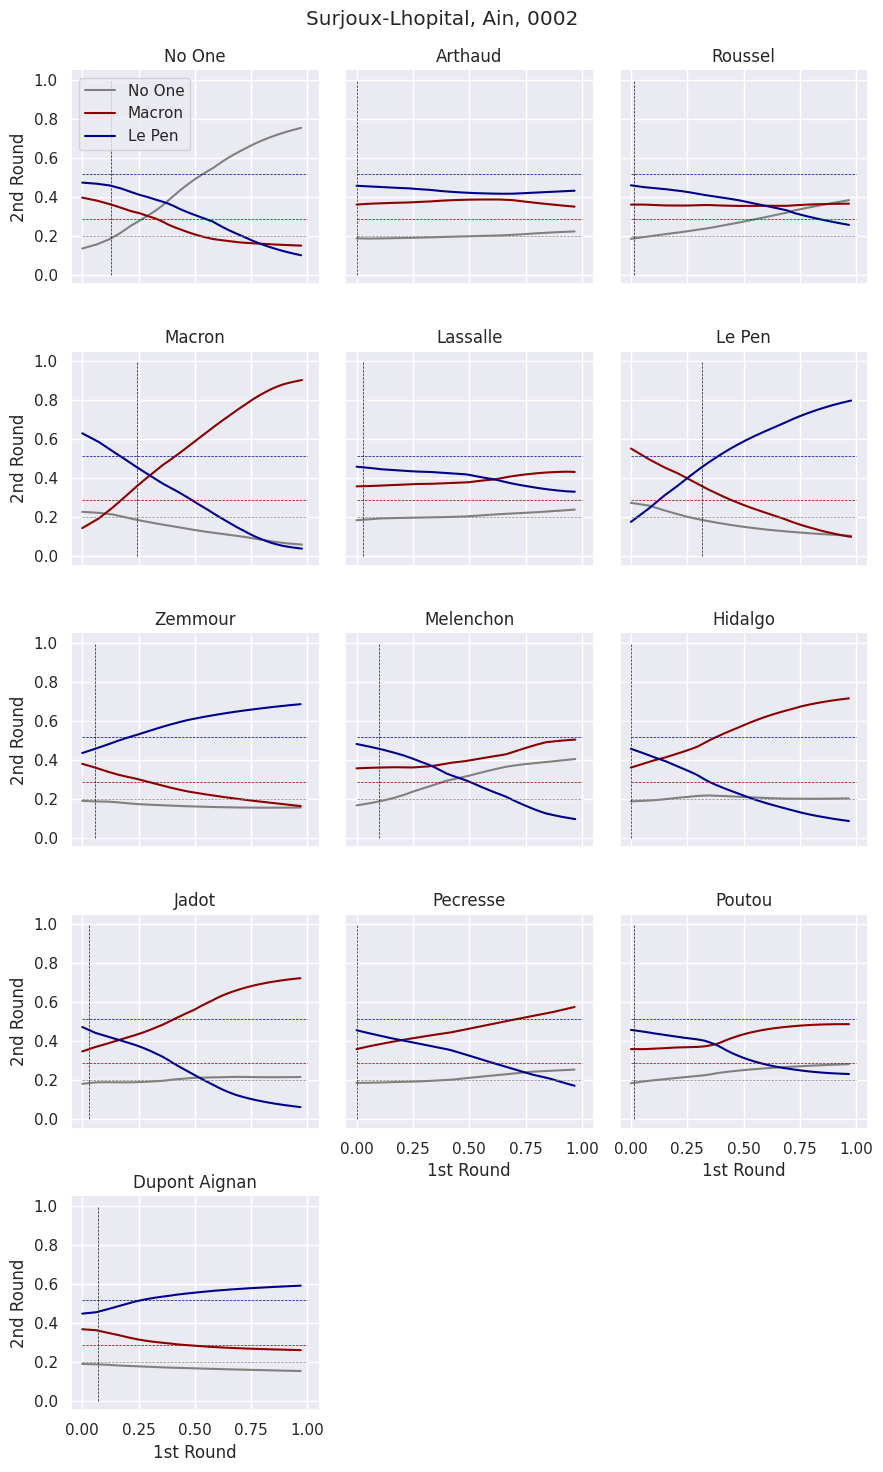

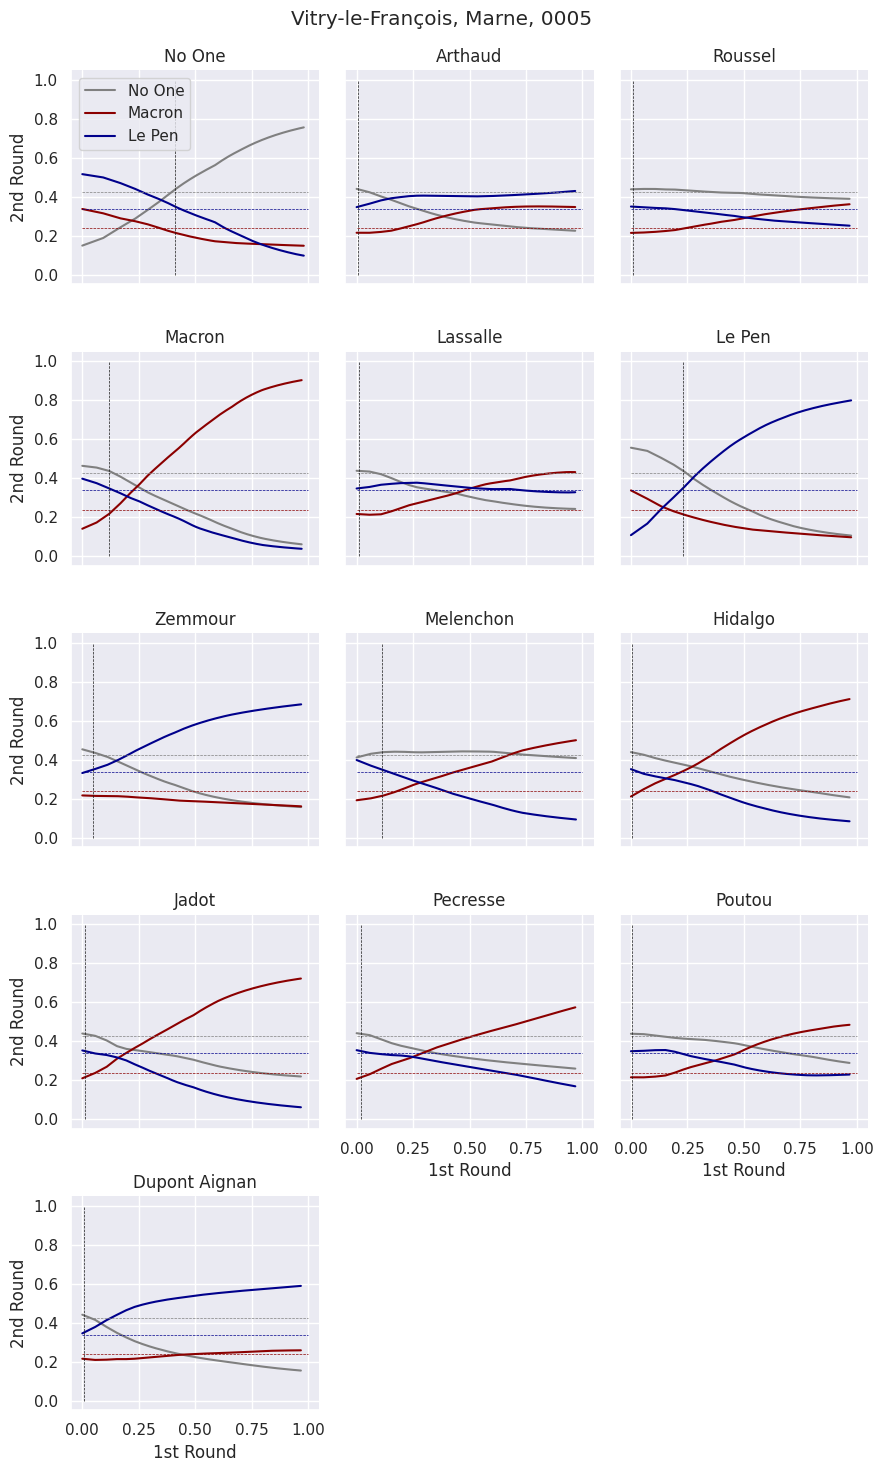

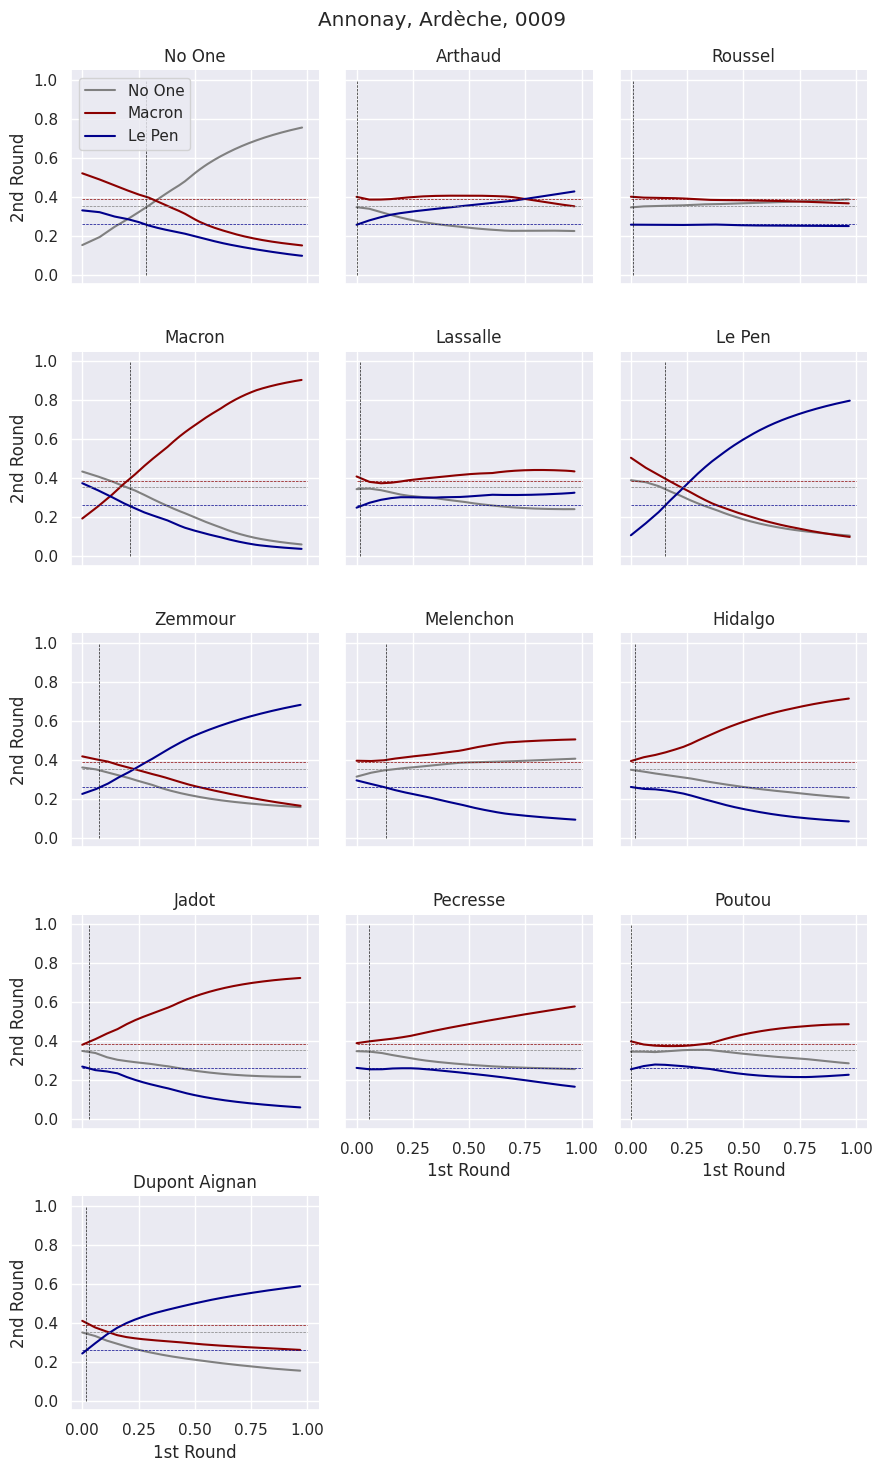

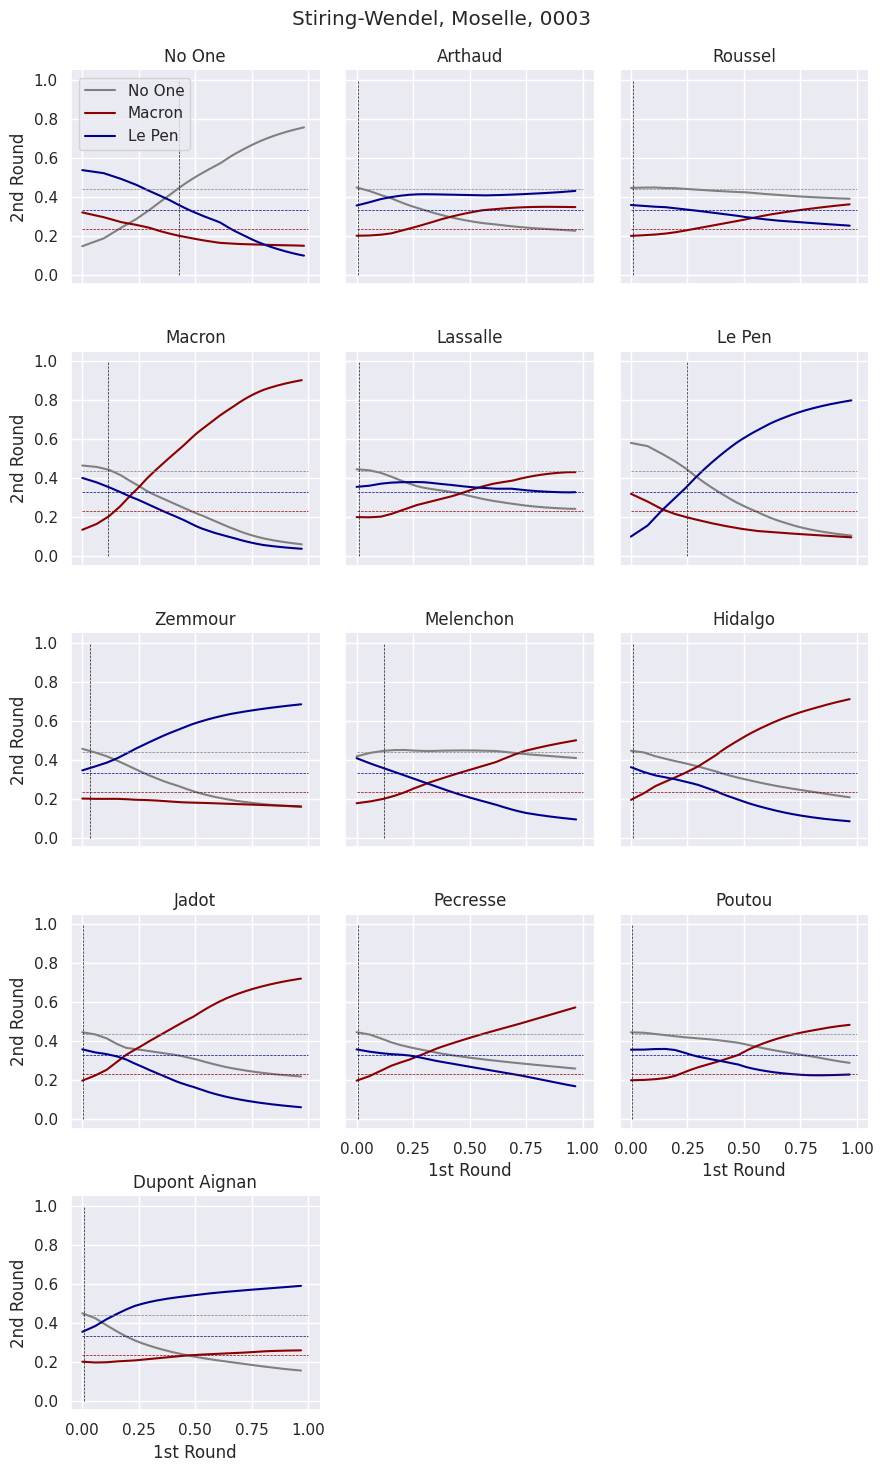

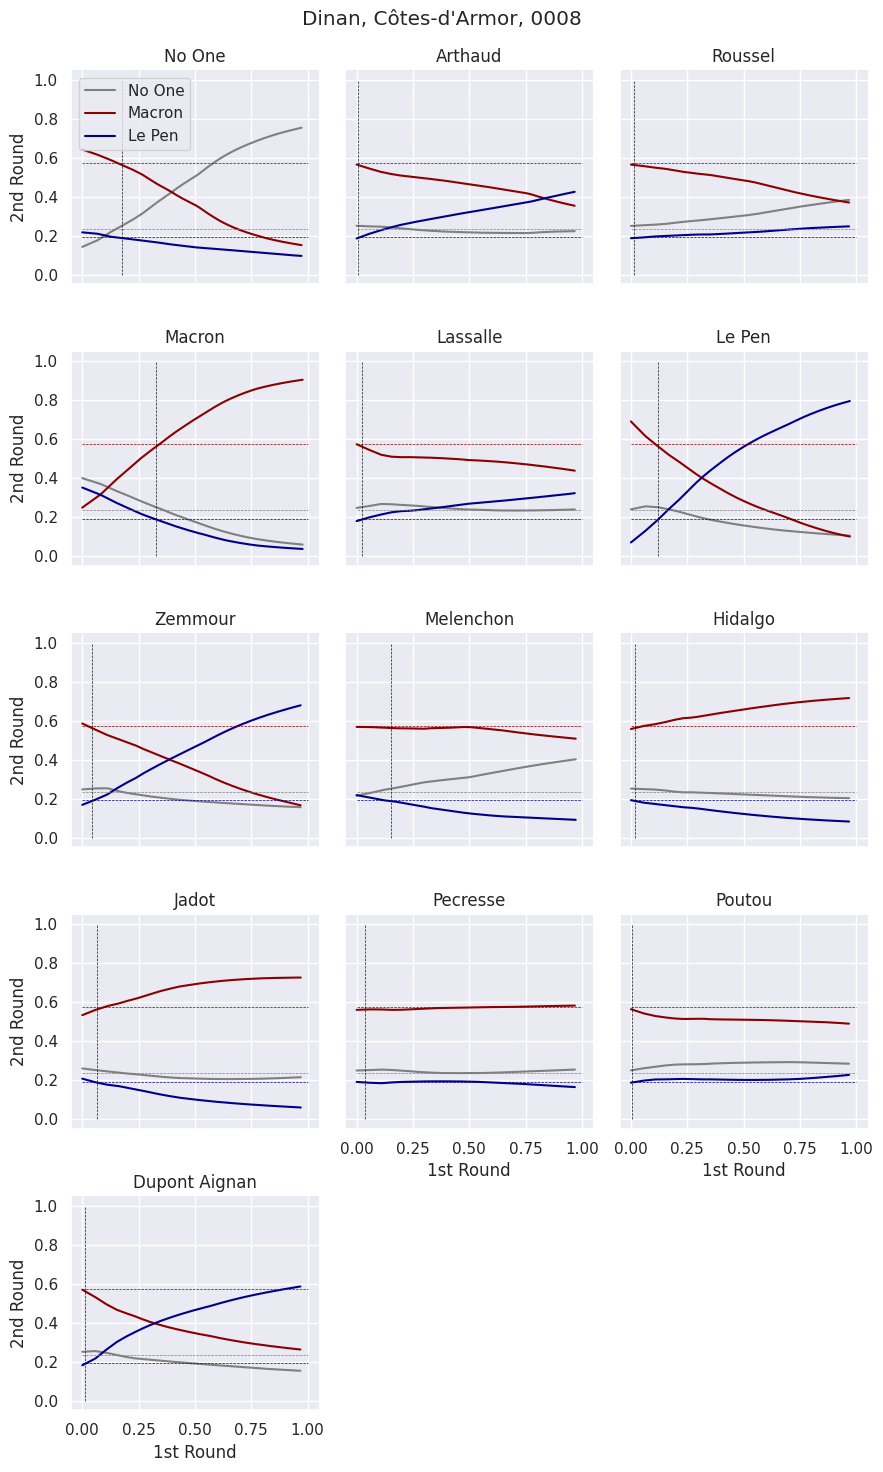

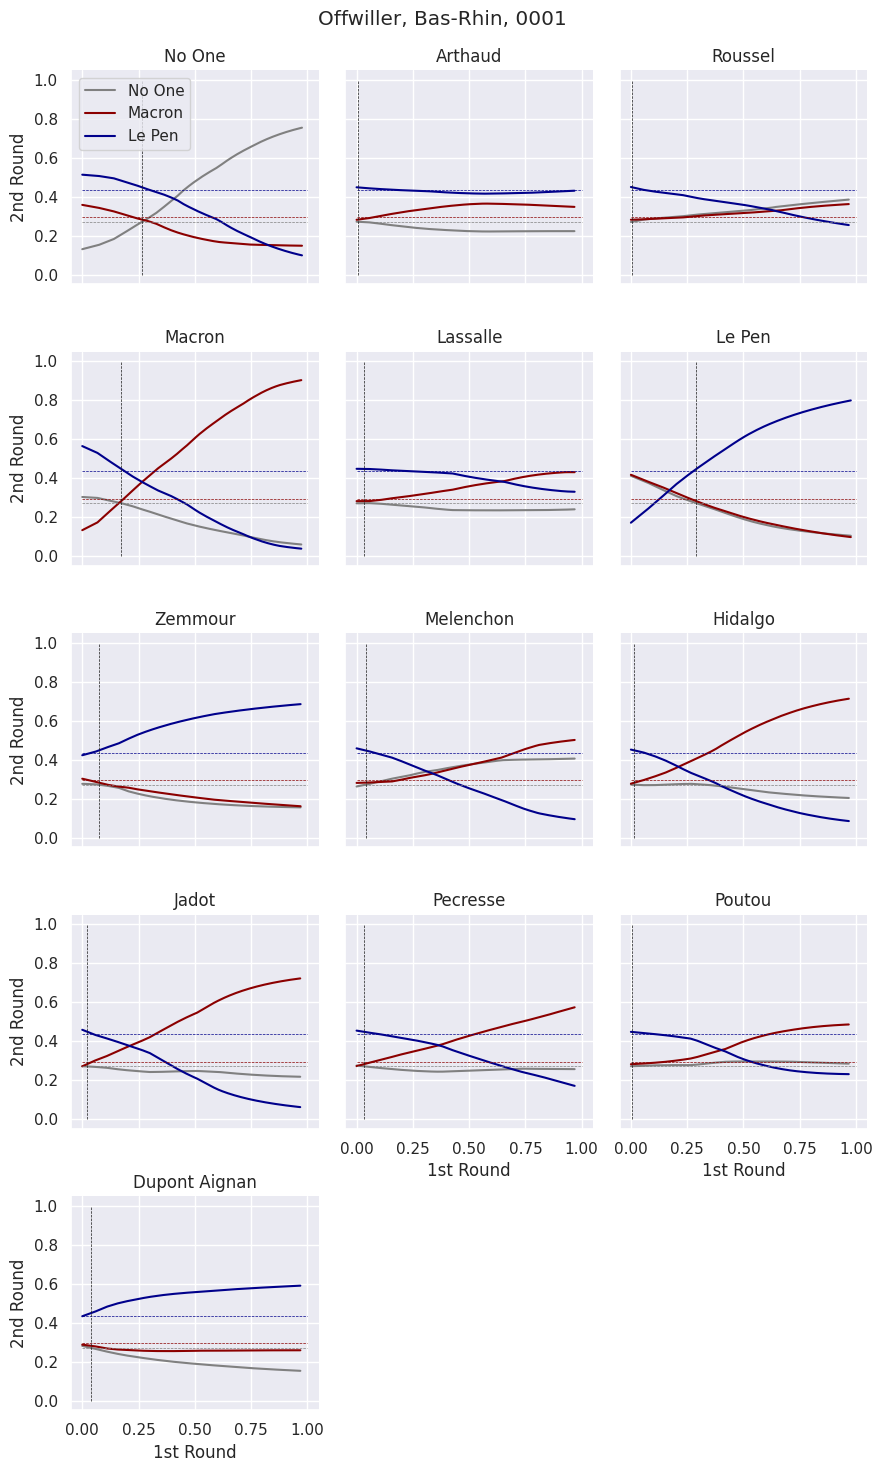

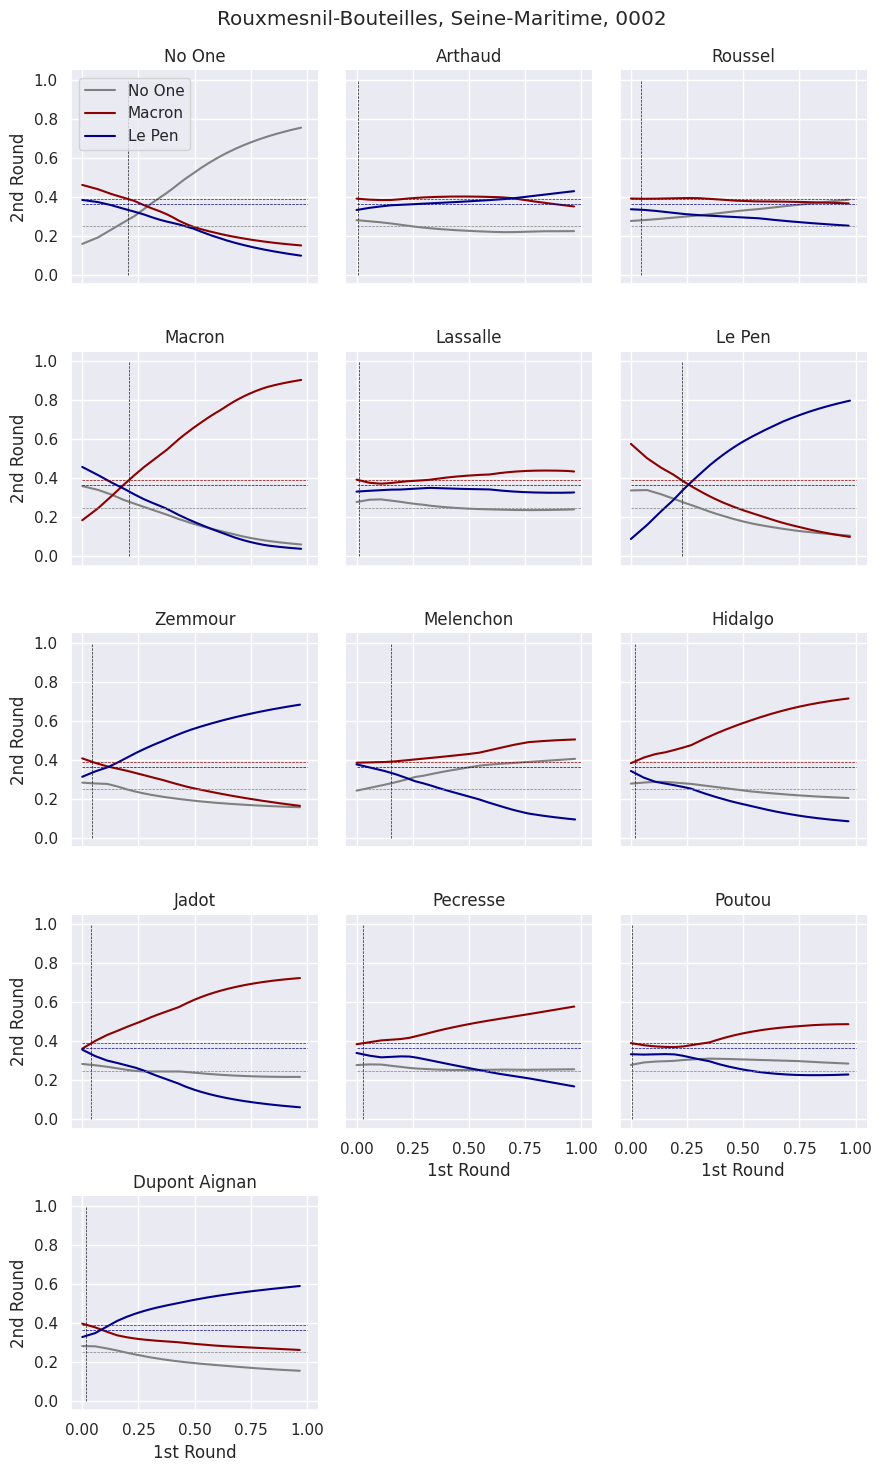

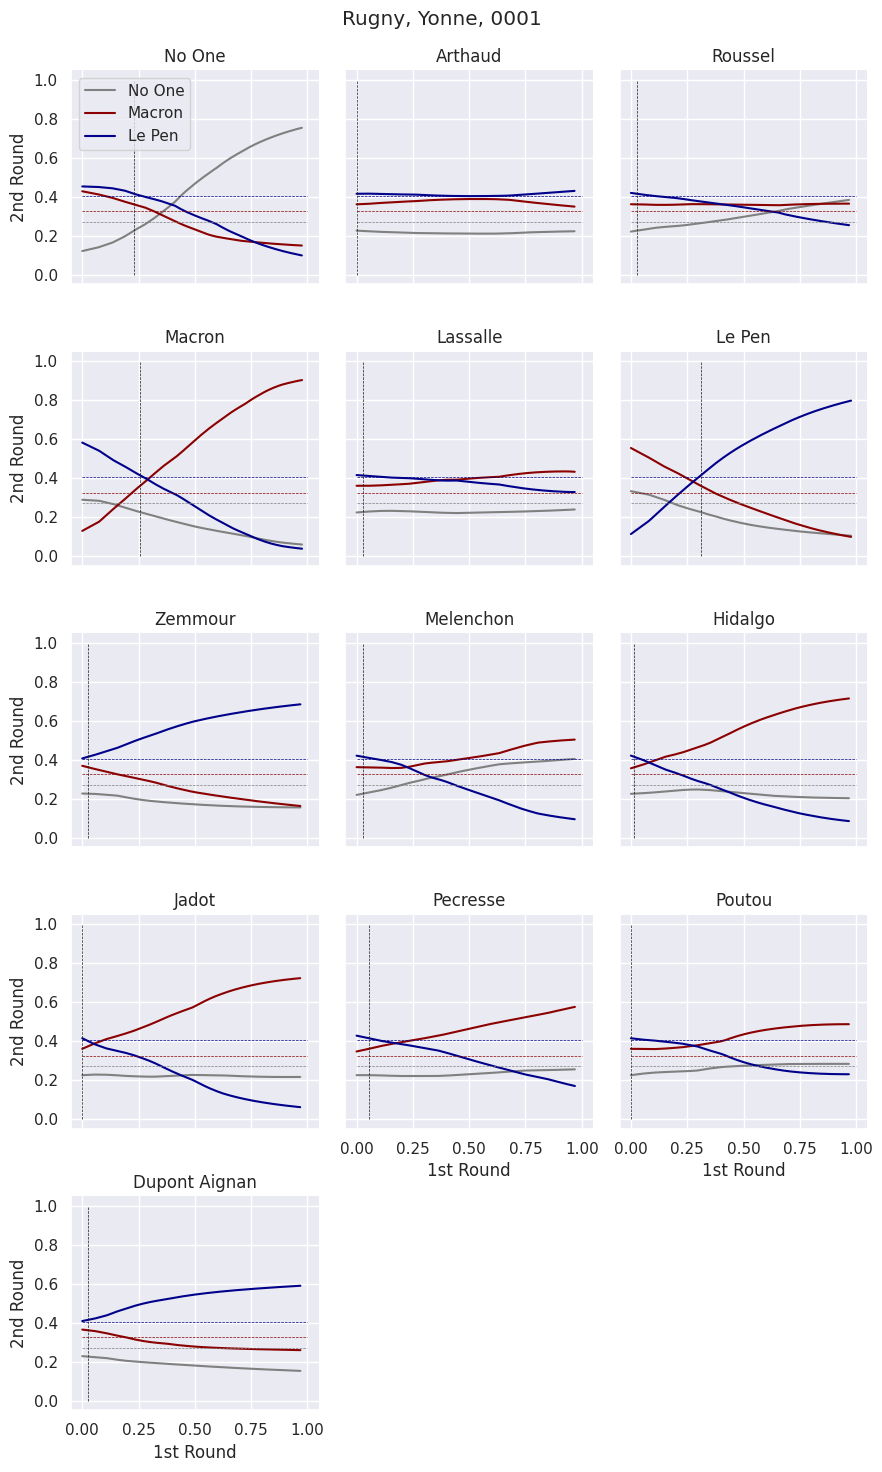

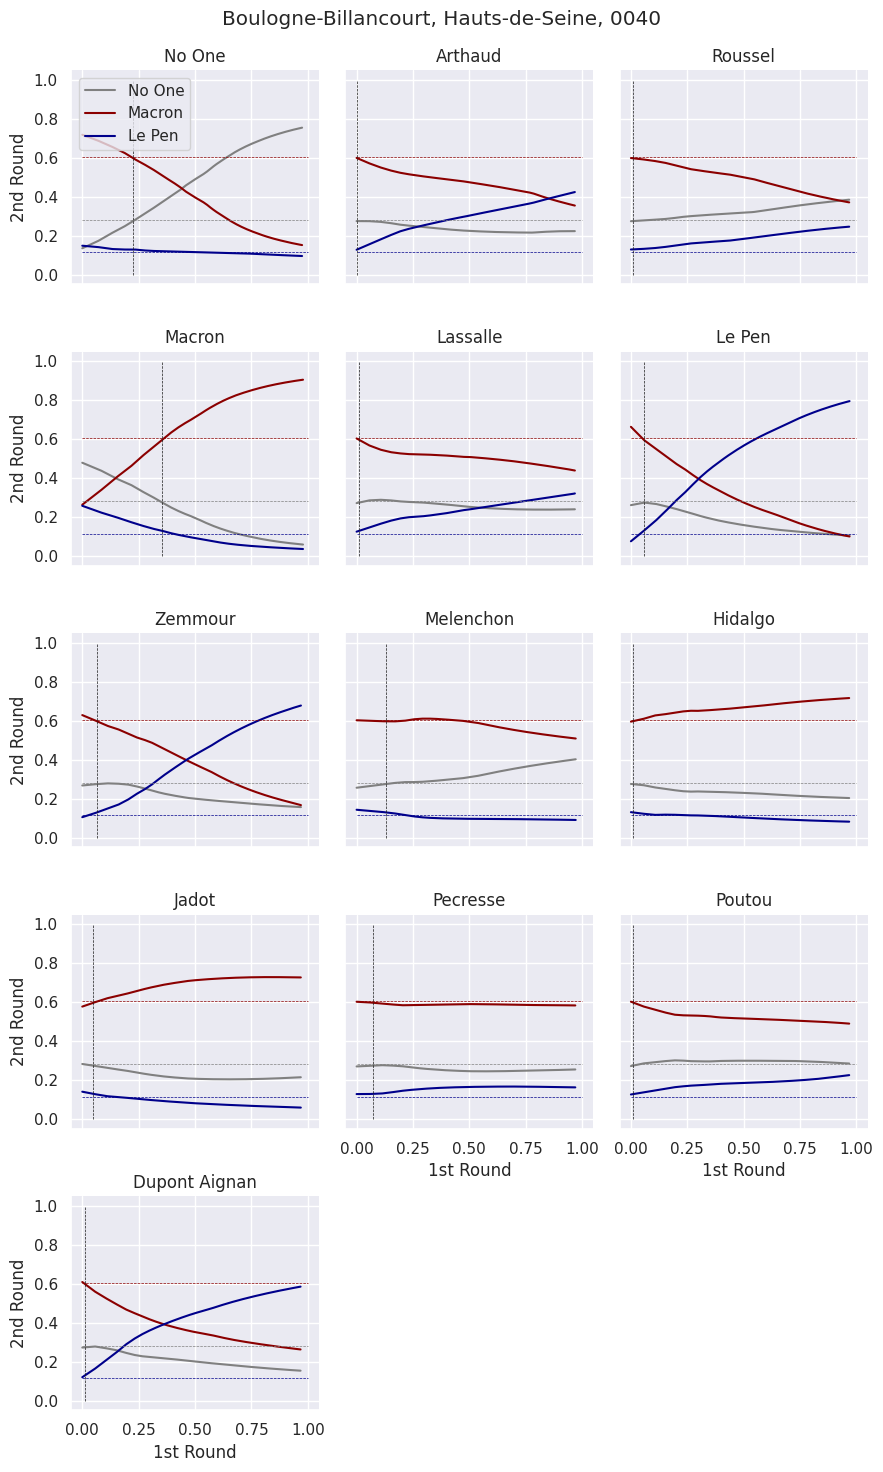

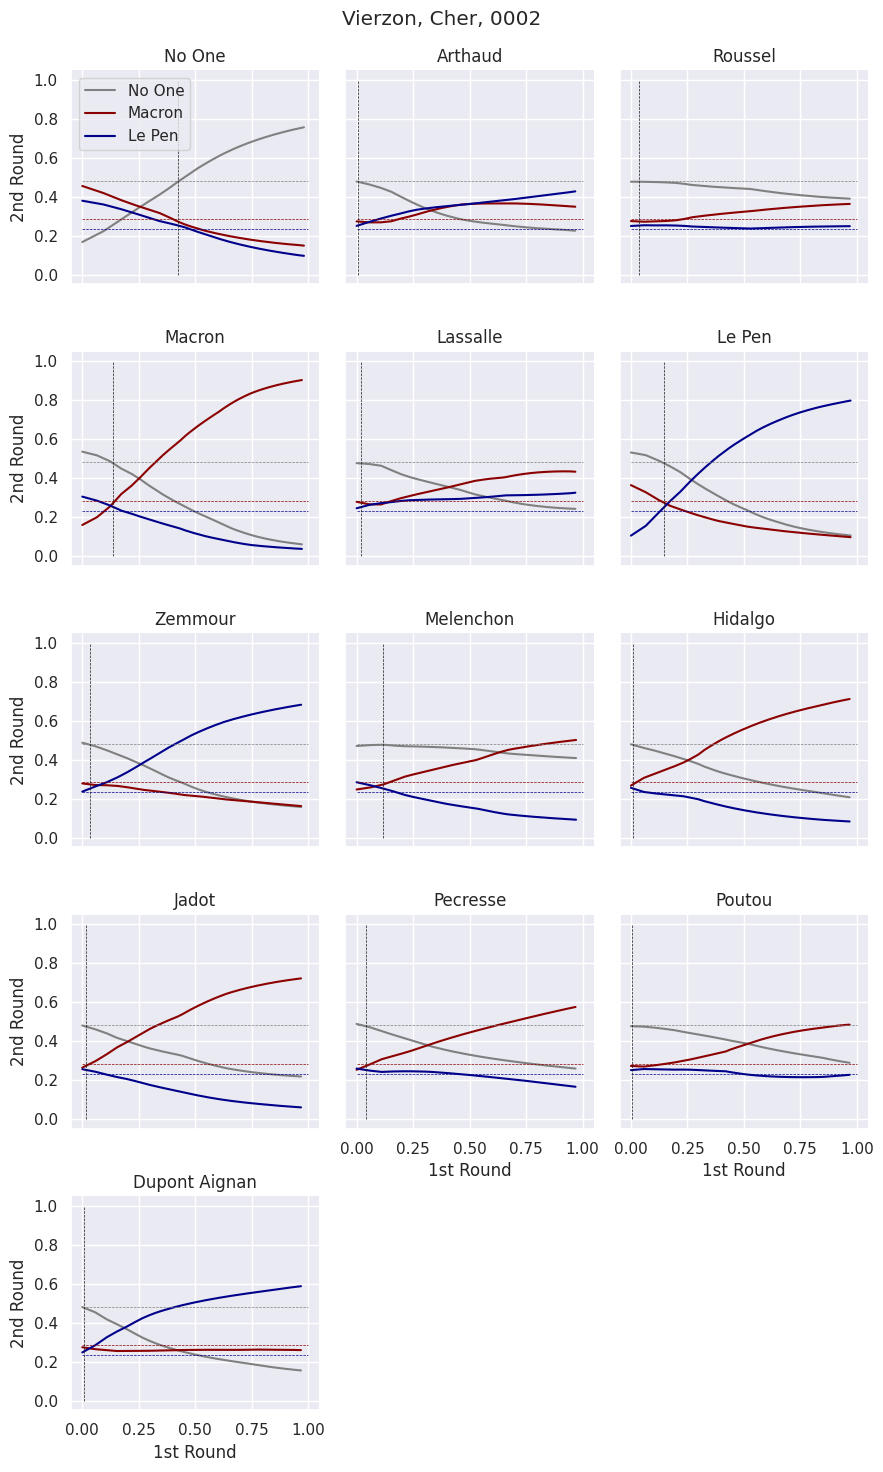

In [6]:
np.random.seed(63)
station_indices = np.random.randint(size=15, low=0, high=prop2.shape[0])

for station_index in station_indices:
    new_prop2_hat = predict_hypothetical_results(station_index=station_index,
                                                prop1=prop1,
                                                model=model)
    plot_hypothetical_results(new_prop2_hat=new_prop2_hat,
                            station_index=station_index,
                            df1=df1,
                            prop1=prop1,
                            prop2=prop2)

## Looking at residuals

There seems to be some structure in the error. 

The model does not predict equally well for every department. In particular, it performs  worse for departments outside of metropolitan France.

In [7]:
prop2_all.groupby('CodeDepartement')[
    'Macron_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZA    0.326663
ZC    0.306084
ZB    0.231421
ZS    0.164676
ZD    0.147247
ZP    0.108081
2B    0.081893
ZM    0.071582
70    0.067805
52    0.064523
55    0.064390
32    0.062760
2A    0.062624
10    0.061978
08    0.061505
23    0.060525
ZN    0.060088
58    0.059413
09    0.059044
02    0.058930
ZZ    0.056148
48    0.055477
39    0.055450
15    0.052791
88    0.052686
Name: Macron_Residual, dtype: float32

In [8]:
prop2_all.groupby('CodeDepartement')[
    'Le_Pen_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZA    0.561335
ZB    0.543532
ZC    0.500924
ZS    0.406535
ZD    0.400770
ZZ    0.277543
ZP    0.252321
ZW    0.141985
ZX    0.090338
75    0.067016
2B    0.065710
48    0.065363
64    0.062517
32    0.058745
65    0.058654
05    0.058236
46    0.058141
93    0.057474
92    0.056955
ZM    0.056409
94    0.056154
53    0.055534
55    0.055464
80    0.055176
ZN    0.054592
Name: Le_Pen_Residual, dtype: float32

In [9]:
prop2_all.groupby('CodeDepartement')[
    'No_One_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZD    0.160427
ZP    0.091555
52    0.084925
55    0.082230
ZW    0.081162
70    0.076237
ZS    0.075404
80    0.075332
ZM    0.073947
15    0.073886
ZX    0.073332
08    0.070631
21    0.070225
39    0.069242
14    0.069090
48    0.068818
10    0.068341
32    0.068129
23    0.065827
02    0.063755
61    0.062634
51    0.060312
50    0.060107
46    0.059772
58    0.059754
Name: No_One_Residual, dtype: float32

We also seem to be making higher errors when there are fewer registered voters.

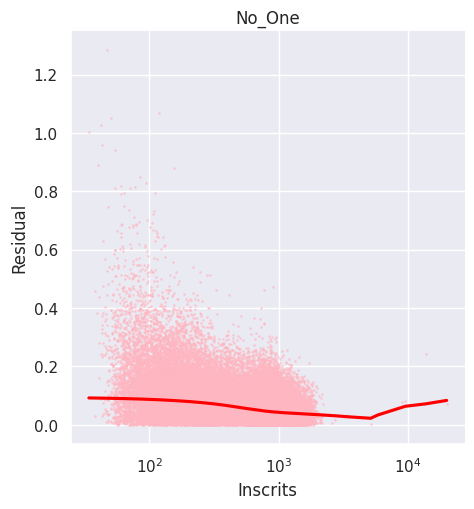

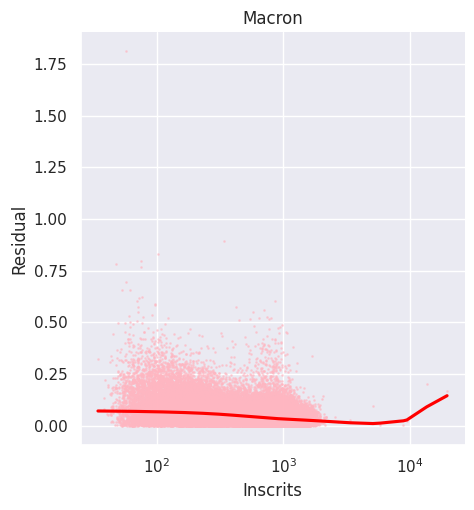

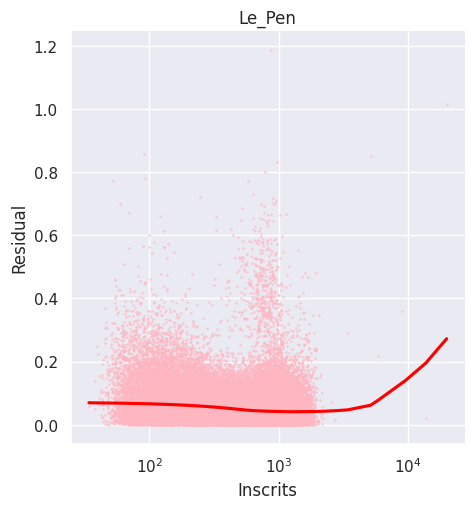

In [10]:
for choice in colnames['choices2']:
    sns.lmplot(
        data=prop2_all,
        x='Inscrits',
        y=f'{choice}_Residual',
        line_kws={'color': 'red'},
        scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5},
        lowess = True)
    plt.xscale("log")
    plt.ylabel("Residual")
    plt.title(choice)
    plt.show()